In [1]:
import os
import pickle
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)

from lvmdrp.core import image
from lvmdrp.functions import imageMethod
from lvmdrp.utils import database
from lvmdrp.utils import bitmask

from lvmdrp.main import load_master_config

In [2]:
config = load_master_config()

db = database.create_or_connect_db(config)

raw_flats = database.LVMFrames.select().where(
    (database.LVMFrames.imagetyp == "flat") &
    (database.LVMFrames.status == bitmask.ReductionStatus["RAW"]) &
    (database.LVMFrames.flags == bitmask.QualityFlag["OK"])
).order_by(database.LVMFrames.exptime.asc())

In [3]:
# for each flat frame
    # 	read raw frame
    #   remove overscan regions
    # 	split into amplifiers
    # 	for each amplifier
    #	 	calculate statistics (mean, variance, median, kurt, skew)
    # 		decide which frames/amplifiers go into gain calculation based in skew and kurt
    # plot sigma_counts vs sqrt(mean_counts)
    # fit slope

N_FLATS = raw_flats.count()

cache_path = "_data-lvm/gain-amps.pk"
if os.path.isfile(cache_path):
    fmin, fmax, mean, sdev, kurt, skew = pickle.load(open(cache_path, "rb"))
else:
    mean, sdev = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    skew, kurt = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    fmin, fmax = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    exptimes = np.zeros(N_FLATS)
    for j, raw_flat in tqdm(enumerate(raw_flats), total=N_FLATS, desc="fetching raw flats", unit="frame", ascii=True):

        flat = image.loadImage(raw_flat.path)
        ab, cd = flat.split(2, axis="Y")
        (a, b), (c, d) = ab.split(2, axis="X"), cd.split(2, axis="X")
        # reflect b and d amplifiers to have the overscan regions in the last columns
        b.orientImage("X")
        d.orientImage("X")
        amps = [a, b, c, d]
        for i, (amp_name, amp) in enumerate(zip(mean.keys(), amps)):
            amps[i].cutOverscan(("1","2040"), ("1","2040"), subtract=False)
            stats = describe(amps[i]._data, axis=None)
            mean[amp_name][j] = stats.mean
            sdev[amp_name][j] = np.sqrt(stats.variance)
            kurt[amp_name][j] = stats.kurtosis
            skew[amp_name][j] = stats.skewness
            fmin[amp_name][j], fmax[amp_name][j] = stats.minmax
    
    pickle.dump((fmin, fmax, mean, sdev, kurt, skew), open(cache_path, "wb"))


fetching raw flats: 100%|##########| 1200/1200 [14:21<00:00,  1.39frame/s]


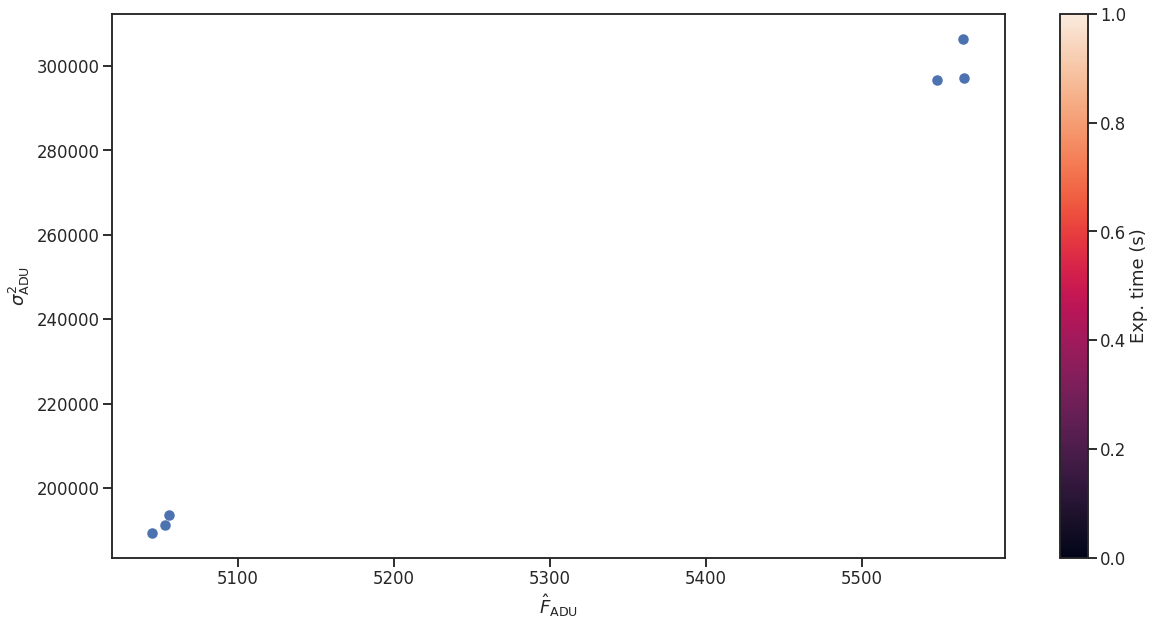

In [19]:
exptimes = np.asarray([raw_flat.exptime for raw_flat in raw_flats])
mjd = np.asarray([raw_flat.mjd for raw_flat in raw_flats])
# exptimes /= exptimes.max()

y, x = sdev["d"]**2, mean["d"]
mask = np.ones_like(exptimes, dtype=bool)
mask &= (y>=100**2)&(y<=600**2)
mask &= (x>=3000)&(x<=40000)

plt.figure(figsize=(20,10))
plt.scatter(x[mask], y[mask])
cb = plt.colorbar()
plt.ylabel(r"$\sigma_\mathrm{ADU}^2$")
plt.xlabel(r"${\hat{F}_\mathrm{ADU}}$")
cb.set_label(r"Exp. time (s)")
# plt.xlim(0, 100)